# ROC AUC 
https://www.datatechnotes.com/2019/11/how-to-create-roc-curve-in-python.html   
https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/   
https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/  
https://glassboxmedicine.com/2020/07/14/the-complete-guide-to-auc-and-average-precision-simulations-and-visualizations/ 

In [1]:
def create_confusion_matrix(model, X, y, labels):
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import numpy as np

    # normalize confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for title, normalize in titles_options:
        if normalize == None:
            i = ax1
        else:
            i = ax2
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X,
            y,
            display_labels=labels,
            cmap=plt.cm.Blues,
            normalize=normalize,
            ax=i,
        )
        disp.ax_.set_title(title)

        plt.grid(False)
        print(title)
        print(disp.confusion_matrix)

    plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from collections import Counter
import warnings
import omdml 

warnings.filterwarnings('ignore')

# Import some data to play with
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)
df = X.copy()
df['target'] = y
df.sample(frac=1, replace=True, random_state=42)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)
print(Counter(y_train), 'mean: ', y_train.mean().round(4))
print(Counter(y_test), 'mean: ', y_test.mean().round(4))
X_train.head()


Counter({1: 250, 0: 148}) mean:  0.6281
Counter({1: 107, 0: 64}) mean:  0.6257


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
469,11.62,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,13.36,25.40,88.14,528.1,0.17800,0.28780,0.31860,0.14160,0.2660,0.09270
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905
443,10.57,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,...,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736
362,12.76,18.84,81.87,496.6,0.09676,0.07952,0.02688,0.01781,0.1759,0.06183,...,13.75,25.99,87.82,579.7,0.12980,0.18390,0.12550,0.08312,0.2744,0.07238
271,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,0.06270,...,12.32,16.18,78.27,457.5,0.13580,0.15070,0.12750,0.08750,0.2733,0.08022


In [237]:
fpr[::-1]


array([0.  , 0.  , 0.  , 0.02, 0.02, 0.05, 0.05, 0.06, 0.06, 0.08, 0.08,
       0.09, 0.09, 1.  ])

In [247]:
# fpr[::-1].sort()  # sort descending order
t = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'thresholds': thresh})
t
# plt.plot(thresh);


,tpr,fpr,thresholds
0,0.000000,0.000000,1.999941
1,0.009346,0.000000,0.999941
2,0.878505,0.000000,0.973005
3,0.878505,0.015625,0.970456
4,0.925234,0.015625,0.909156
5,0.925234,0.046875,0.800590
6,0.953271,0.046875,0.765748
7,0.953271,0.062500,0.753281
8,0.981308,0.062500,0.704928
9,0.981308,0.078125,0.642970


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def auroc_graph(model, X, y, label=None, title=None):
    """Plot Area under ROC curve

    Args:
        model (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_
        label (_type_, optional): _description_. Defaults to None.
    """
    fpr, tpr, thresh = metrics.roc_curve(
        y_true=y, y_score=model.predict_proba(X)[:, 1])
    y_pred = model.predict_proba(X)[:, 1]
    auc = metrics.roc_auc_score(y_true=y, y_score=y_pred)
    fig, ax = plt.subplots(figsize=(8, 5))

    if title:
        title = 'ROC Curve ({})'.format(title)
    else:
        title = 'ROC Curve'

    if label:
        label = 'AUC {0:} (area = {1:0.2f}'.format(label, auc)
    else:
        label = 'AUC model (area = {0:0.2f}'.format(auc)

    ax.plot(fpr, tpr, label=label)
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], color='orange', ls='--', label='Random')
    ax.legend()
    ax.grid(alpha=0.5)

# Precision-Recall Curve
def pr_curve(model, X, y, title=None):
    """Creates Precision-Recall Curve

    Args:
        model (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_
    """

    y_pred = model.predict_proba(X)[:, 1]
    auprc = metrics.average_precision_score(y, y_pred)

    # Containers for true positive / false positive rates
    precision_scores = []
    recall_scores = []

    thresholds = np.linspace(0, 1, num=10)

    for i in thresholds:
        precision, recall, threshold = metrics.precision_recall_curve(y, y_pred)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # AUPRC baseline
    ratio = np.round(len(y[y==1]) / len(y), 2)
    if title:
        title_graph = '{0:s}\nPrecision/Recall Curve (AUPRC baseline: {1:0.2f})'.format(title, ratio)
    else:
        title_graph = 'Precision/Recall Curve (AUPRC baseline: {0:0.2f})'.format(ratio)
    plt.plot(recall_scores[0], precision_scores[0], color='steelblue')
    plt.xlim(0.0, 1.05), plt.ylim(np.min(precision_scores)-0.05), 1.05
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title_graph)
    plt.text(0.35, ((1-0.04+np.min(precision_scores))/2), 'AUPRC: ' + str(auprc.round(4)),
        bbox=dict(facecolor='red', alpha=0.5))
    plt.grid(True, alpha=0.5)
    plt.show()

In [ ]:
metrics.get_scorer_names()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from collections import Counter
import warnings
from imblearn.over_sampling import RandomOverSampler, SMOTE
import omdml 

warnings.filterwarnings('ignore')

# Import some data to play with
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)
df = X.copy()
df['target'] = y
df.sample(frac=1, replace=True, random_state=42)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)
print(Counter(y_train), 'mean: ', y_train.mean().round(4))
print(Counter(y_test), 'mean: ', y_test.mean().round(4))
X_train.head()

# create balanced dataset
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(Counter(y_resampled), 'mean: ', y_resampled.mean().round(4))

Counter({1: 250, 0: 148}) mean:  0.6281
Counter({1: 107, 0: 64}) mean:  0.6257
Counter({1: 250, 0: 250}) mean:  0.5


In [5]:
learning_rate = np.round(np.arange(0.1, 1.1, 0.1).tolist(), 1)
n_estimators = np.arange(10, 1000, 10).tolist()
eta = []
trees = []
accuracy_train = []
auc_train = []
auprc_train = []
accuracy_test = []
auc_test = []
auprc_test = []

for j in range(len(learning_rate)):
    for i in range(len(n_estimators)):

        # use cross-validation
        # use gridsearch
        
        model = XGBClassifier(learning_rate = learning_rate[j], 
                              n_estimators = n_estimators[i], 
                              max_depth=3, 
                              subsample=0.7, 
                              random_state=42, verbosity=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_resampled, y_resampled, scoring='accuracy', cv=kfold)
        accuracy_train.append(scores.mean())
        scores = cross_val_score(model, X_resampled, y_resampled, scoring='roc_auc', cv=kfold)
        auc_train.append(scores.mean())
        scores = cross_val_score(model, X_resampled, y_resampled, scoring='average_precision', cv=kfold)
        auprc_train.append(scores.mean())
        
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        accuracy_test.append(metrics.accuracy_score(y_test, y_pred))
        y_pred = model.predict_proba(X_test)[:, 1]
        auc_test.append(metrics.roc_auc_score(y_test, y_pred))
        auprc_test.append(metrics.average_precision_score(y_test, y_pred))
        trees.append(n_estimators[i])
        eta.append(learning_rate[j])

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42, use_label_encoder=False,
                        verbosity=0, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        grid = GridSearchCV(xgb, params, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    grid.fit(X_resampled, y_resampled)
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Best score: {:.5f}".format(best_score))   

In [ ]:
import warnings

warnings.simplefilter('ignore')

params={
    'n_estimators':np.arange(10, 1000, 10).tolist(),
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
    'max_depth':[3],
    'subsample':[0.7]
}
grid_search(params)

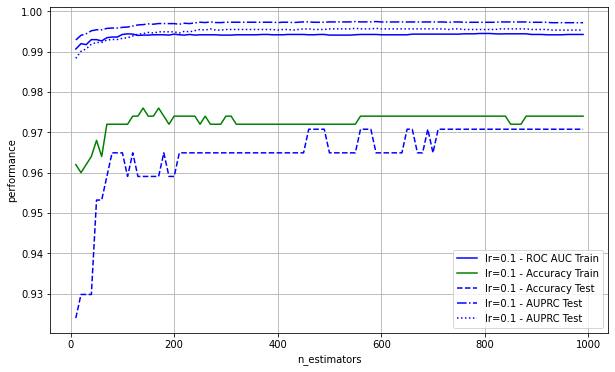

In [19]:
import pandas as pd

plt.figure(figsize=(10, 6))
df_results = pd.DataFrame({'learning_rate': eta, 'n_estimators': trees, 
                           'accuracy_test': accuracy_test, 'auc_test': auc_test, 'auprc_test': auprc_test, 
                           'accuracy_train': accuracy_train, 'auc_train': auc_train, 'auprc_train': auprc_train})
df_results.set_index('n_estimators', inplace=True)

plt.plot(df_results[df_results['learning_rate'] == 0.1]['auc_train'], label='lr=0.1 - ROC AUC Train', c='blue')

plt.plot(df_results[df_results['learning_rate'] == 0.1]['accuracy_train'], label='lr=0.1 - Accuracy Train', c='green')
# plt.plot(df_results[df_results['learning_rate'] == 0.2]['accuracy_train'], label='lr=0.2 - Accuracy Train', c='green')

plt.plot(df_results[df_results['learning_rate'] == 0.1]['accuracy_test'], label='lr=0.1 - Accuracy Test', ls='--', c='blue')
# plt.plot(df_results[df_results['learning_rate'] == 0.2]['accuracy_test'], label='lr=0.2 - Accuracy Test', ls='--', c='green')
# plt.plot(df_results[df_results['learning_rate'] == 0.3]['accuracy_test'], label='lr=0.3 - Accuracy Test', ls='--', c='red')
# plt.plot(df_results[df_results['learning_rate'] == 0.4]['accuracy_test'], label='lr=0.4 - Accuracy Test', ls='--', c='grey')
# plt.plot(df_results[df_results['learning_rate'] == 0.5]['accuracy_test'], label='lr=0.5 - Accuracy Test', ls='--', c='black')
# plt.plot(df_results[df_results['learning_rate'] == 0.6]['accuracy_test'], label='lr=0.6 - Accuracy Test', ls='--', c='purple')
# plt.plot(df_results[df_results['learning_rate'] == 0.7]['accuracy_test'], label='lr=0.7 - Accuracy Test', ls='--', c='brown')
# plt.plot(df_results[df_results['learning_rate'] == 0.8]['accuracy_test'], label='lr=0.8 - Accuracy Test', ls='--', c='orange')
# plt.plot(df_results[df_results['learning_rate'] == 0.9]['accuracy_test'], label='lr=0.9 - Accuracy Test', ls='--', c='lighblue')
# plt.plot(df_results[df_results['learning_rate'] == 1]['accuracy_test'], label='lr=1')

plt.plot(df_results[df_results['learning_rate'] == 0.1]['auprc_test'], label='lr=0.1 - AUPRC Test', ls='-.', c='blue')

plt.plot(df_results[df_results['learning_rate'] == 0.1]['auc_test'], label='lr=0.1 - AUPRC Test', ls='dotted', c='blue')

plt.xlabel('n_estimators')
plt.ylabel('performance')
plt.legend()
plt.grid(True);

In [20]:
df_results.head(100)

,learning_rate,accuracy_test,auc_test,auprc_test,accuracy_train,auc_train,auprc_train
n_estimators,,,,,,,
10,0.1,0.923977,0.988318,0.992875,0.962,0.99064,0.986091
20,0.1,0.929825,0.990070,0.994029,0.960,0.99196,0.989200
30,0.1,0.929825,0.990654,0.994409,0.962,0.99172,0.986554
40,0.1,0.929825,0.991822,0.995143,0.964,0.99296,0.991798
50,0.1,0.953216,0.992261,0.995408,0.968,0.99296,0.991316
...,...,...,...,...,...,...,...
960,0.1,0.970760,0.995327,0.997154,0.974,0.99424,0.991852
970,0.1,0.970760,0.995327,0.997154,0.974,0.99424,0.991852
980,0.1,0.970760,0.995327,0.997154,0.974,0.99424,0.991852


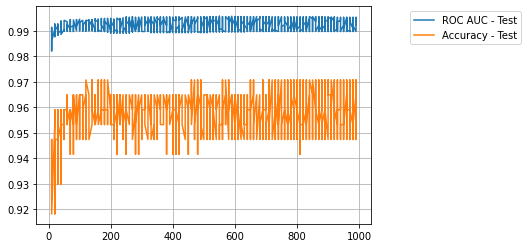

In [21]:
m = df_results.copy()
m.sort_index(inplace=True)
plt.plot(m['auc_test'], label='ROC AUC - Test')
plt.plot(m['accuracy_test'], label='Accuracy - Test')
plt.legend(bbox_to_anchor=(1.1, 1.), loc='upper left')
plt.grid(True);

In [22]:
from sklearn.model_selection import cross_validate, cross_val_score

params={'learning_rate': 0.6, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.7}
params={'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 780, 'subsample': 0.7}

xgb = XGBClassifier(**params, random_state=42, verbosity=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=kfold)
print('Accuracy - Train: {0:0.4f}'.format(scores.mean()))
xgb.fit(X_resampled, y_resampled)
y_score = xgb.predict(X_test)
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_score)
print('Accuracy Test: {0:0.4f}'.format(accuracy))
y_score = xgb.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_true=y_test, y_score=y_score)
print('ROC AUC Test: {0:0.4f}'.format(auc))

Accuracy - Train: 0.9740
Accuracy Test: 0.9708
ROC AUC Test: 0.9955


In [ ]:
Accuracy - Train: 0.9800
Accuracy Test: 0.9591
ROC AUC Test: 0.9927

In [ ]:
pd.options.display.max_columns=None
pd.options.display.max_rows=100
df_results[df_results['learning_rate']==0.1].head(100)

In [ ]:
df_results[(df_results['learning_rate'] == 0.1)&(df_results.index>500)]

In [268]:
df_results.head()

,learning_rate,accuracy_test,auc_test,auprc,accuracy_train,auc_train
n_estimators,,,,,,
10,0.1,0.923977,0.988318,0.992875,0.974178,0.994194
20,0.1,0.929825,0.990070,0.994029,0.974178,0.994194
30,0.1,0.929825,0.990654,0.994409,0.974178,0.994194
40,0.1,0.929825,0.991822,0.995143,0.974178,0.994194
50,0.1,0.953216,0.992261,0.995408,0.974178,0.994194


Resampled:  [(0, 250), (1, 250)]
Test:  [(0, 64), (1, 107)]
Accuracy Train: 1.0000
Accuracy Test: 0.9708
ROC AUC Train: 1.0000
ROC AUC Test: 0.9955


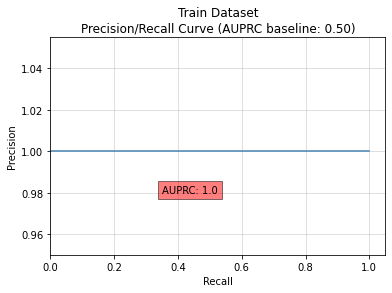

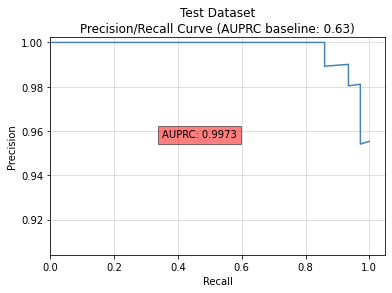

Classification Report: Test
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        64
           1       0.96      1.00      0.98       107

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

Confusion matrix, without normalization
[[ 59   5]
 [  0 107]]
Normalized confusion matrix
[[0.92 0.08]
 [0.   1.  ]]


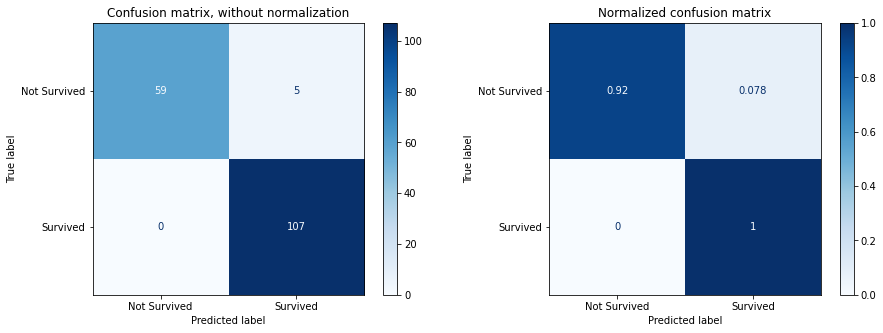

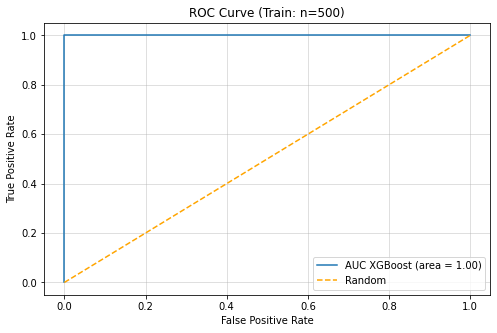

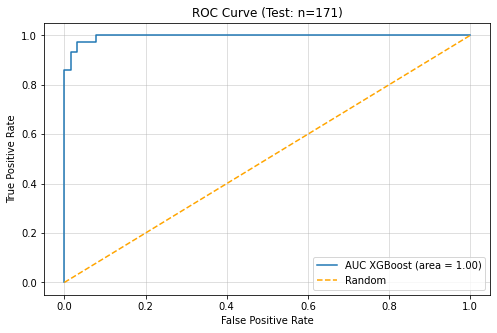

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

print('Resampled: ', sorted(Counter(y_resampled).items()))
print('Test: ', sorted(Counter(y_test).items()))

params = {
    'learning_rate': 0.1, 
    'n_estimators': 780, 
    'max_depth': 3, 
    'subsample': 0.7
}
# params={'learning_rate': 0.6, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.7}

model = XGBClassifier(**params, random_state=42, verbosity=0)
# model = LogisticRegression()
model.fit(X_resampled, y_resampled)
omdml.accuracy(y_resampled, model.predict(X_resampled), label='Train')
omdml.accuracy(y_test, model.predict(X_test), label='Test')
omdml.auc_score(model, X_resampled, y_resampled, label='Train')
omdml.auc_score(model, X_test, y_test, label='Test')
omdml.pr_curve(model, X_resampled, y_resampled, 'Train Dataset')
omdml.pr_curve(model, X_test, y_test, 'Test Dataset')
print('Classification Report: Test')
print(metrics.classification_report(y_test, model.predict(X_test)))
omdml.create_confusion_matrix(model, X_test, y_test, ['Not Survived', 'Survived'])
omdml.auroc_graph(model, X_resampled, y_resampled, label='XGBoost', title='Train')
omdml.auroc_graph(model, X_test, y_test, label='XGBoost', title='Test')

In [25]:
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric="aucpr", eval_set=eval_set, early_stopping_rounds=30, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(model)

[0]	validation_0-aucpr:0.94231
[1]	validation_0-aucpr:0.97688
[2]	validation_0-aucpr:0.97764
[3]	validation_0-aucpr:0.99064
[4]	validation_0-aucpr:0.99114
[5]	validation_0-aucpr:0.99129
[6]	validation_0-aucpr:0.99096
[7]	validation_0-aucpr:0.99170
[8]	validation_0-aucpr:0.99163
[9]	validation_0-aucpr:0.99220
[10]	validation_0-aucpr:0.99224
[11]	validation_0-aucpr:0.99256
[12]	validation_0-aucpr:0.99274
[13]	validation_0-aucpr:0.99350
[14]	validation_0-aucpr:0.99350
[15]	validation_0-aucpr:0.99320
[16]	validation_0-aucpr:0.99347
[17]	validation_0-aucpr:0.99367
[18]	validation_0-aucpr:0.99409
[19]	validation_0-aucpr:0.99418
[20]	validation_0-aucpr:0.99372
[21]	validation_0-aucpr:0.99416
[22]	validation_0-aucpr:0.99408
[23]	validation_0-aucpr:0.99416
[24]	validation_0-aucpr:0.99407
[25]	validation_0-aucpr:0.99450
[26]	validation_0-aucpr:0.99430
[27]	validation_0-aucpr:0.99452
[28]	validation_0-aucpr:0.99469
[29]	validation_0-aucpr:0.99478
[30]	validation_0-aucpr:0.99478
[31]	validation_0-

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


params = {
    'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 3, 'subsample': 0.7
}

model = XGBClassifier(**params, random_state=42, verbosity=0)
# model = LogisticRegression()
model.fit(X_train, y_train)
y_score = model.predict(X_train)
print('Accuracy Train: {0:0.4f}'.format(
    accuracy_score(y_true=y_train, y_pred=y_score)))
y_score = model.predict_proba(X_train)[:, 1]  # proba of positive samples
auc = roc_auc_score(y_train, y_score)
print('ROC AUC Score Train: {0:0.4f}'.format(auc))

y_score = model.predict(X_test)
print('Accuracy Test: {0:0.4f}'.format(
    accuracy_score(y_true=y_test, y_pred=y_score)))
y_score = model.predict_proba(X_test)[:, 1]  # proba of positive samples
auc = roc_auc_score(y_test, y_score)
print('ROC AUC Score Test: {0:0.4f}'.format(auc))
auprc = average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
print('AUPRC Test: {0:0.4f}\n'.format(auprc))

# print(model)

print(classification_report(y_test, model.predict(X_test)))
omdml.create_confusion_matrix(model, X_test, y_test, ['No Cancer', 'Cancer'])

fpr, tpr, thresh = roc_curve(
    y_true=y_test, y_score=model.predict_proba(X_test)[:, 1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(fpr, tpr, label='ROC Curve (area = %.2f)' % auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2,
         color='orange', label='Random guess')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.grid()
ax1.legend()
ax2.set_title('PR Curve')
ax2.set_xlabel('Recall: Positive Label 1')
ax2.set_ylabel('Precision: Positive Label 1')
ax2.grid()
ax2.legend()

display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="XGBoost", ax=ax2
)


Accuracy Train: 1.0000
ROC AUC Score Train: 1.0000
Accuracy Test: 0.9649
ROC AUC Score Test: 0.9946
AUPRC Test: 0.9968

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        64
           1       0.95      1.00      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



NameError: name 'omdml' is not defined

In [283]:
x1 = 6 / (10000+6)
x2 = 1 / (10000+1)
print('FPR={0:0.6f}'.format(x1))
print('FPR={0:0.6f}'.format(x2))


FPR=0.000600
FPR=0.000100


---
ARIMA

In [7]:
from statsmodels.tsa import stattools

a = [1,2,3,4,5,6,7,8,9]
b = [3,4,5,6,7,8,9,10,11]
xcorr = stattools.ccf(a, b, adjusted=True)

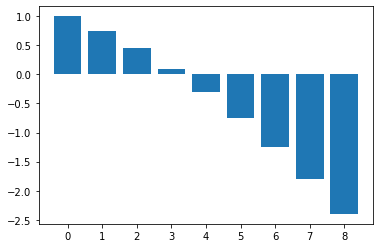

In [11]:
plt.bar(height=xcorr, x=[str(i) for i in range(len(a))]);